In [42]:
import pandas as pd
import geopandas
import numpy as np
from math import pi
from matplotlib import pyplot as plt
import seaborn as sns
import common.common_pandas_lib as common

### Configuraciones librerias

In [43]:
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (18, 8)

sns.set(style="whitegrid", font_scale = 2) # seteando tipo de grid en seaborn
                                           # seteando tamanio de ticks label
pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

### Configuraciones plot

In [44]:
TAM_TITULO = 35
TAM_ETIQUETA = 30
COLORES_BARRAS = 'colorblind'

### Funciones auxiliares

#### Graficos

In [45]:
font_size = 18

def crear_mapa(series, caracteristica, vmin, vmax, titulo, titulo_barra, color):
    #Creo mi mapa de mexico
    mexico = geopandas.read_file('Data/mexstates.shp') #Los estados pueden ser vistos con mexico.ADMIN_NAME

    #Le pongo los tildes al archivo de estados para que me coincidan con las provincias
    mexico["ADMIN_NAME"].replace({'Nuevo Leon': "Nuevo León",
                               "San Luis Potosi": "San luis Potosí",
                               "Queretaro": "Querétaro",
                               "Yucatan": "Yucatán",
                               "Michoacan": "Michoacán",
                               "Mexico": "Edo. de México",
                               "Baja California": "Baja California Norte"}, inplace=True)

    #Hago un nuevo dataframe con la información del mapa y la antiguedad para cada provincia
    gdf = mexico.set_index("ADMIN_NAME").join(series)
    
    #Grafico el mapa

    #Base donde se va a dibujar
    fig, base = plt.subplots(1, figsize=(10, 6))

    #Si les parece que los ejes están de más, pongan off
    base.axis("on")

    #Pido que me coloreé en base a la caracteristica determinada
    gdf.plot(column=caracteristica, cmap=color, linewidth=0.8, ax=base, edgecolor="0.8")

    #Setteo el título al gráfico
    base.set_title(titulo, fontsize = font_size)
    
    #Agrego la barra que indica la antiguedad
    # l:left, b:bottom, w:width, h:height
    cbax = fig.add_axes([1, 0.15, 0.02, 0.65])   
    cbax.set_title(titulo_barra)
    sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = fig.colorbar(sm, cax=cbax)

def crear_plot(data, x, y, caracteristica, paleta, titulo, titulo_barra, xlabel, ylabel):
    grafico = sns.barplot(
        x = x, 
        hue = caracteristica,
        y = y,
        data = data,
        palette = paleta
    )
    grafico.set_title(titulo, fontsize = TAM_TITULO)
    grafico.set_xlabel(xlabel, fontsize = TAM_ETIQUETA)
    grafico.set_ylabel(ylabel, fontsize = TAM_ETIQUETA)
    grafico.legend(title = titulo_barra)
    plt.show()

#### Otras funciones

In [46]:
def crear_df_precio_caracteristica_boolean(df, caracteristica):
    provincias = df["provincia"].unique()
    
    df_caracteristica_true = df[df[caracteristica] == True]
    df_caracteristica_false = df[df[caracteristica] == False]
    
    precio_caracteristica_true = df_caracteristica_true.groupby("provincia")["precio"].mean()
    precio_caracteristica_false = df_caracteristica_false.groupby("provincia")["precio"].mean()
    
    provincias_col = []
    boolean = []
    precio = []
    
    for provincia in provincias:
        #Para verdadero
        provincias_col.append(provincia)
        boolean.append(True)
        precio.append(precio_caracteristica_true[provincia])
        
        #Para falso
        provincias_col.append(provincia)
        boolean.append(False)
        precio.append(precio_caracteristica_false[provincia])
    
    dic = {"provincias": provincias_col, caracteristica: boolean, "precio": precio}
    return pd.DataFrame(dic)

### Carga optimizada del set de datos

In [47]:
df = pd.read_csv('train.csv', \
       dtype = { \
                'id' : np.int32, \

                'ciudad' : 'category', \
                'antiguedad' : np.float16, \
                'habitaciones' : np.float16, \
                'garages' : np.float16, \
                'banos' : np.float16, \
                'metroscubiertos' : np.float16, \
                'metrostotales' : np.float16, \
                'idzona' : np.float32, \
                'gimnasio' : 'bool', \
                'usosmultiples' : 'bool', \
                'piscina' : 'bool', \
                'escuelascercanas' : 'bool', \
                'centroscomercialescercanos' : 'bool', \
                'precio' : np.float32 \
               },
        parse_dates = ['fecha'],
        date_parser = pd.to_datetime                                
    )

# Escuelas cercanas

## Cantidad de NAN en campos a analizar

### Cantidad de NAN en provincia:

In [48]:
n_provincia_nan = df["provincia"].isnull().sum()
n_provincia_nan

155

### Cantidad de NAN en escuelascercanas:

In [49]:
n_escuelascercanas_nan = df["escuelascercanas"].isnull().sum()
n_escuelascercanas_nan

0

In [50]:
df = df.dropna(subset=["provincia"])

## Valores

### ¿Qué valores puede tomar escuelascercanas?

In [51]:
escuelascercanas_valores = df["escuelascercanas"].unique()
escuelascercanas_valores.sort()
escuelascercanas_valores

array([False,  True])

### ¿Cuál es el promedio de escuelas cercanas para una propiedad por provincia?

In [52]:
provincia_promedio_escuelas = df.groupby("provincia")["escuelascercanas"].mean()

(<Figure size 1000x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d0383f2e10>)

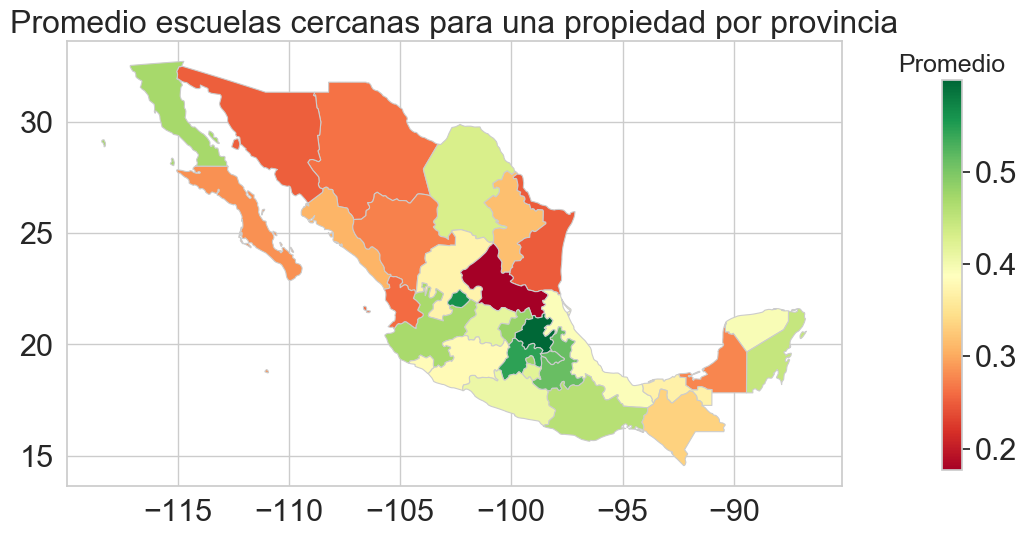

<Figure size 1250x1250 with 0 Axes>

In [53]:
common.crear_mapa(provincia_promedio_escuelas, "escuelascercanas", provincia_promedio_escuelas.min(),
           provincia_promedio_escuelas.max(), "Promedio escuelas cercanas para una propiedad por provincia", "Promedio",
           "RdYlGn")

#### Top 5 provincias con más escuelas

In [54]:
provincia_mayores_promedio_escuelas_df = provincia_promedio_escuelas.nlargest(5).to_frame()
provincia_mayores_promedio_escuelas_df.columns = ["Mayores promedios de escuelas cercanas"]
provincia_mayores_promedio_escuelas_df.index.names = ["Provincia"]
provincia_mayores_promedio_escuelas_df

,Mayores promedios de escuelas cercanas
Provincia,
Hidalgo,0.60
Aguascalientes,0.56
Edo. de México,0.54
Tlaxcala,0.52
Puebla,0.51


#### Top 5 provincias con menos escuelas

In [55]:
provincia_menores_promedio_escuelas_df = provincia_promedio_escuelas.nsmallest(5).to_frame()
provincia_menores_promedio_escuelas_df.columns = ["Menores promedios de escuelas cercanas"]
provincia_menores_promedio_escuelas_df.index.names = ["Provincia"]
provincia_menores_promedio_escuelas_df

,Menores promedios de escuelas cercanas
Provincia,
San luis Potosí,0.18
Tamaulipas,0.25
Sonora,0.25
Nayarit,0.26
Chihuahua,0.26


## ¿Varía en promedio el precio de las propiedades según si tienen escuelas cercanas por provincia?

In [56]:
provincias_validas = df["provincia"].value_counts() > 10000
provincias_validas = provincias_validas[provincias_validas == True]
df_reducido = df[df["provincia"].isin(list(provincias_validas.index))]

df_escuelascercanas_precio_boolean = crear_df_precio_caracteristica_boolean(df_reducido, "escuelascercanas")
df_escuelascercanas_precio_boolean

,provincias,escuelascercanas,precio
0,Distrito Federal,True,"3,417,376.25"
1,Distrito Federal,False,"3,521,510.00"
2,Jalisco,True,"2,438,989.00"
3,Jalisco,False,"2,304,753.75"
4,Edo. de México,True,"2,696,654.25"
5,Edo. de México,False,"2,841,233.50"
6,Nuevo León,True,"2,407,734.50"
7,Nuevo León,False,"2,861,878.00"
8,Querétaro,True,"2,156,901.00"
9,Querétaro,False,"2,132,237.25"


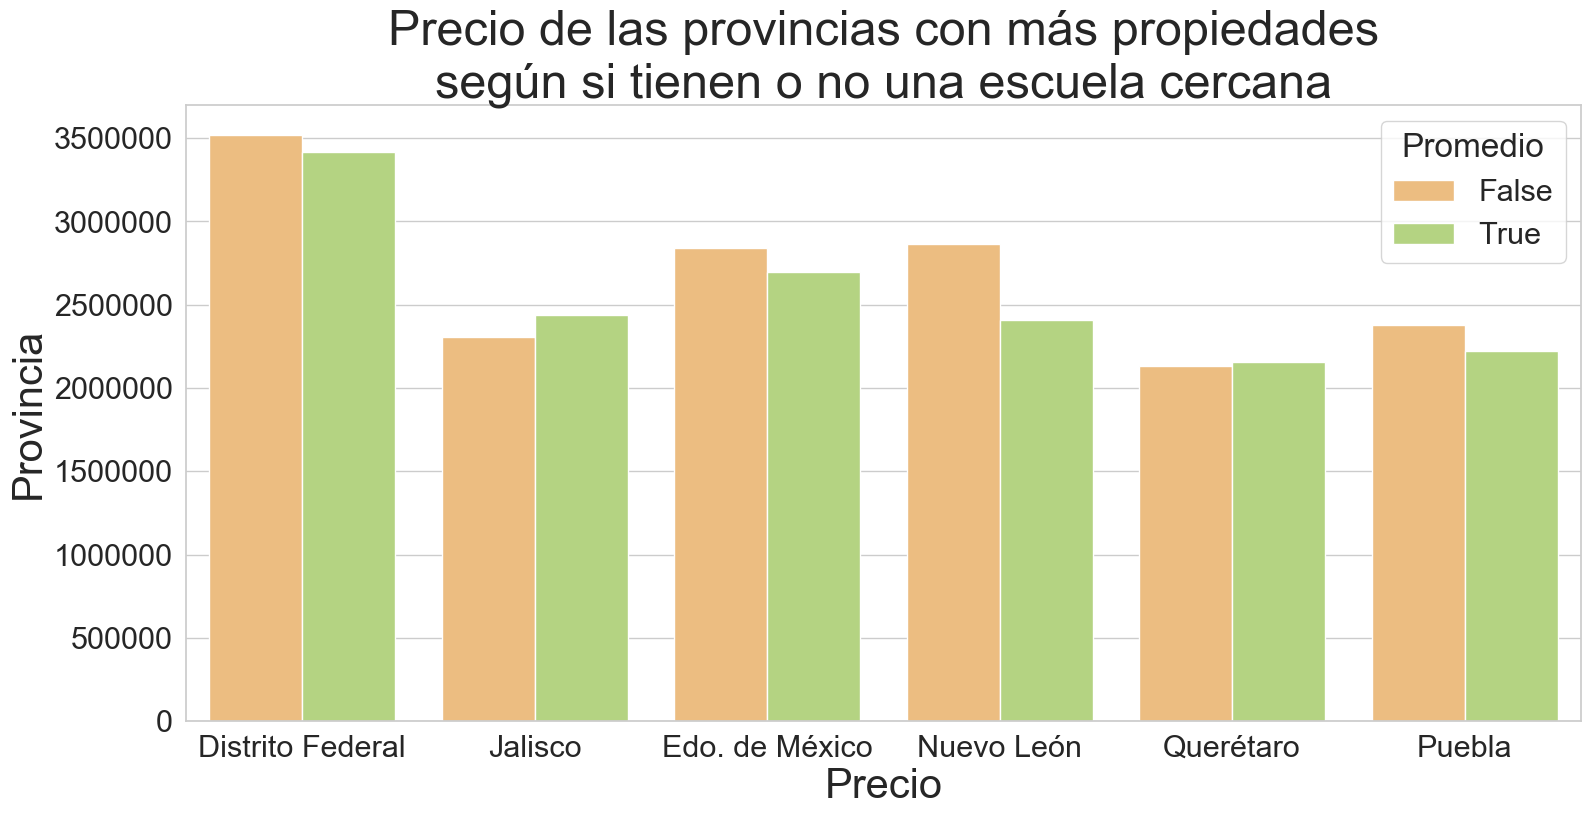

In [57]:
crear_plot(df_escuelascercanas_precio_boolean, "provincias", "precio", "escuelascercanas", "RdYlGn",
           "Precio de las provincias con más propiedades\nsegún si tienen o no una escuela cercana", "Promedio",
           "Precio", "Provincia")

## ¿Las provincias con propiedades más caras poseen mayor promedio de escuelas cercanas por propiedad?

In [58]:
provincia_promedio = df.groupby("provincia").agg({"precio": "mean", "escuelascercanas": "mean"})
provincia_promedio

,precio,escuelascercanas
provincia,,
Aguascalientes,"1,477,188.75",0.56
Baja California Norte,"767,441.75",0.47
Baja California Sur,"1,216,452.88",0.28
Campeche,"1,570,917.88",0.28
Chiapas,"1,924,125.75",0.33
Chihuahua,"1,744,530.62",0.26
Coahuila,"1,505,305.50",0.43
Colima,"1,531,380.12",0.38
Distrito Federal,"3,471,705.00",0.48


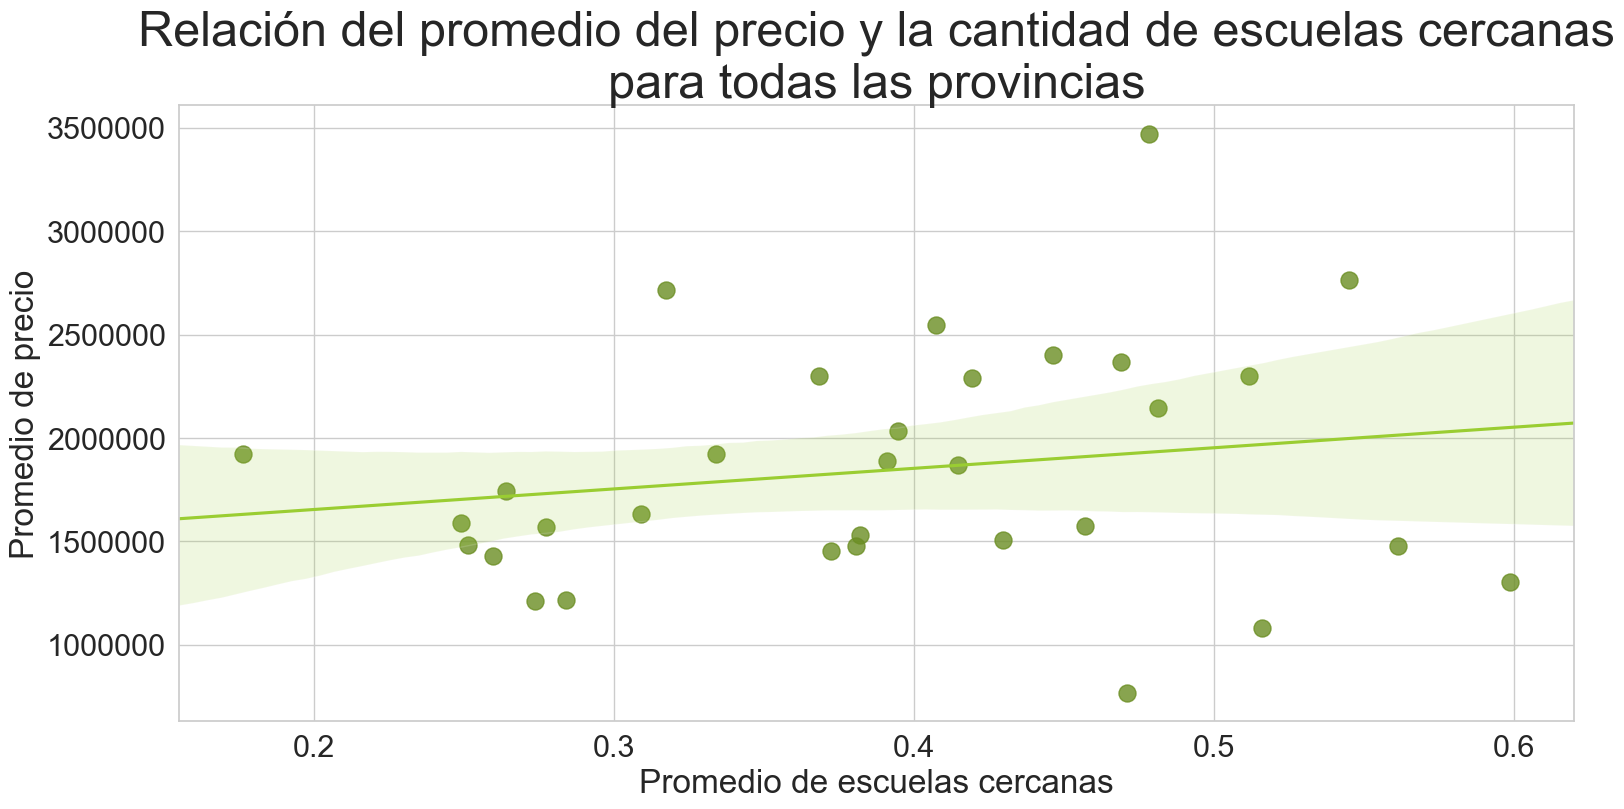

In [59]:
plot_escuela_precio_relacion = sns.regplot(x="escuelascercanas", y="precio", data=provincia_promedio,
                                           scatter_kws={'color': 'olivedrab', 's': 150}, line_kws={'color': 'yellowgreen'})
plot_escuela_precio_relacion.set(xlabel="Promedio de escuelas cercanas", ylabel="Promedio de precio")
plt.title("Relación del promedio del precio y la cantidad de escuelas cercanas\npara todas las provincias", size = TAM_TITULO)
plt.show()


# Centros comerciales cercanos

## Cantidad de NAN en campos a analizar

### Cantidad de NAN en centroscomercialescercanos:

In [60]:
n_centroscomercialescercanos_nan = df["centroscomercialescercanos"].isnull().sum()
n_centroscomercialescercanos_nan

0

## Valores

### ¿Qué valores puede tomar escuelascercanas?

In [61]:
centroscomercialescercanos_valores = df["centroscomercialescercanos"].unique()
centroscomercialescercanos_valores.sort()
centroscomercialescercanos_valores

array([False,  True])

### ¿Cuál es el promedio de escuelas cercanas para una propiedad por provincia?

In [62]:
provincia_promedio_centroscomercialescercanos = df.groupby("provincia")["centroscomercialescercanos"].mean()

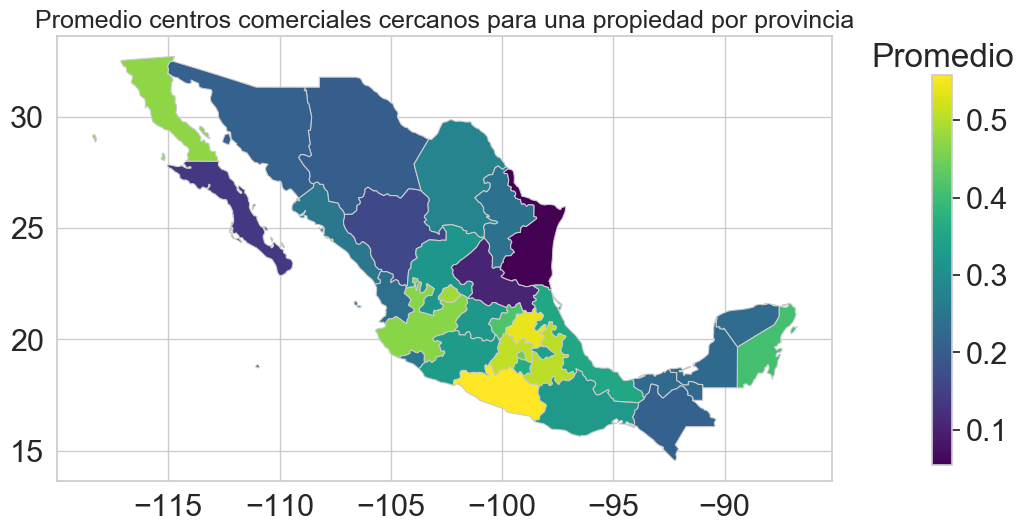

In [63]:
crear_mapa(provincia_promedio_centroscomercialescercanos, "centroscomercialescercanos", provincia_promedio_centroscomercialescercanos.min(),
           provincia_promedio_centroscomercialescercanos.max(),
           "Promedio centros comerciales cercanos para una propiedad por provincia", "Promedio", "viridis")

## ¿Varía en promedio el precio de las propiedades según si tienen centros comerciales cercanos por provincia?

In [64]:
df_centroscomercialescercanos_precio_boolean = crear_df_precio_caracteristica_boolean(df_reducido, "centroscomercialescercanos")
df_centroscomercialescercanos_precio_boolean

,provincias,centroscomercialescercanos,precio
0,Distrito Federal,True,"3,459,431.75"
1,Distrito Federal,False,"3,481,561.75"
2,Jalisco,True,"2,513,928.25"
3,Jalisco,False,"2,238,548.50"
4,Edo. de México,True,"2,708,928.25"
5,Edo. de México,False,"2,818,312.50"
6,Nuevo León,True,"2,403,732.25"
7,Nuevo León,False,"2,817,785.50"
8,Querétaro,True,"2,149,728.75"
9,Querétaro,False,"2,140,089.25"


In [65]:
def crear_plot(data, x, y, caracteristica, paleta, titulo, titulo_barra, xlabel, ylabel):
    grafico = sns.barplot(
        x = x, 
        hue = caracteristica,
        y = y,
        data = data,
        palette = paleta
    )
    grafico.set_title(titulo, fontsize = TAM_TITULO)
    grafico.set_xlabel(xlabel, fontsize = TAM_ETIQUETA)
    grafico.set_ylabel(ylabel, fontsize = TAM_ETIQUETA)
    grafico.legend(title = titulo_barra)
    plt.show()

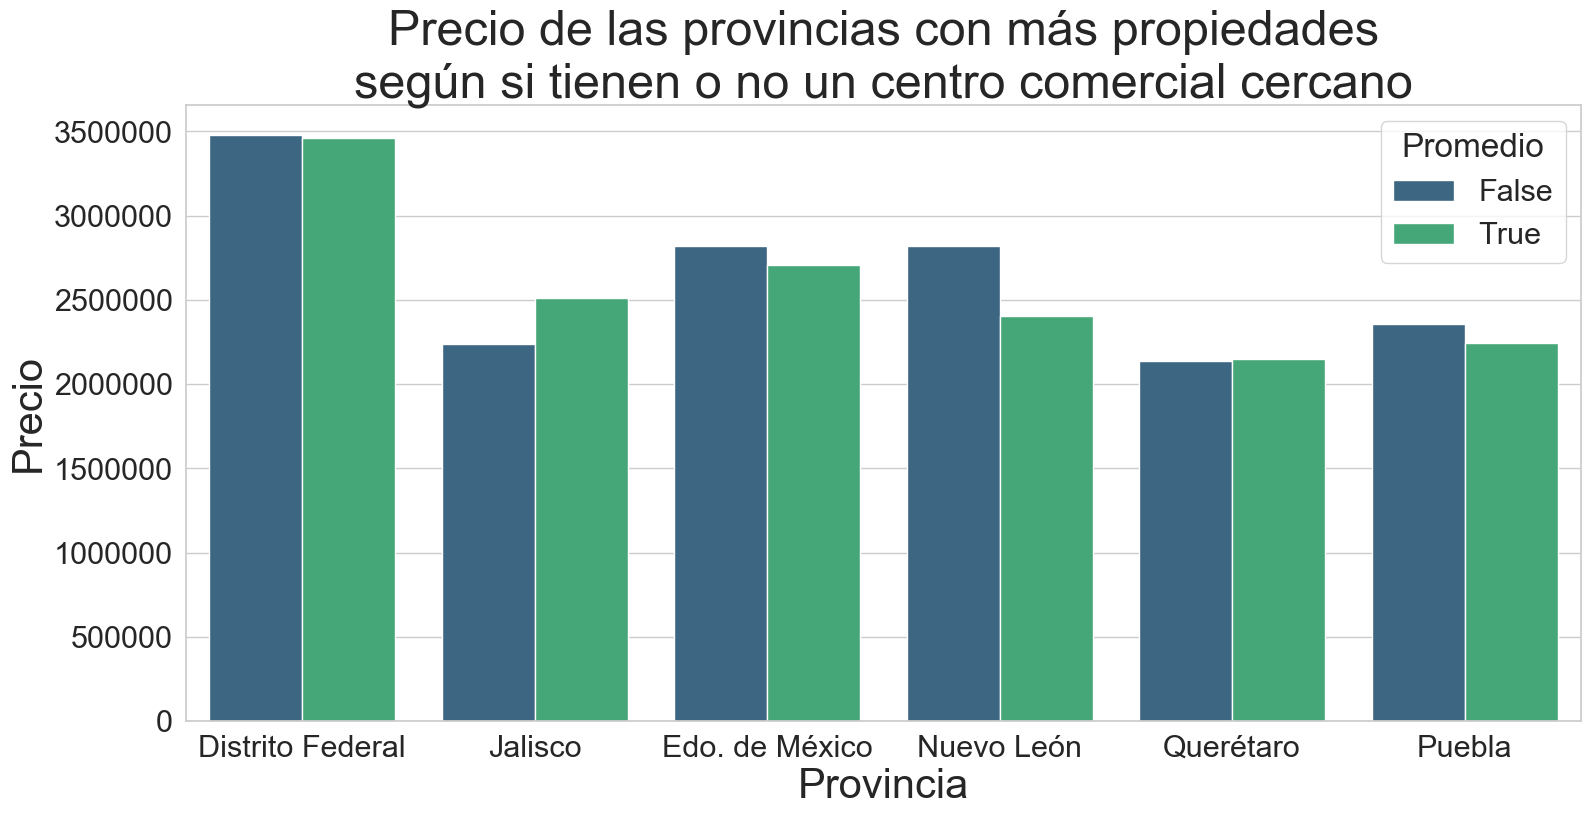

In [66]:
crear_plot(df_centroscomercialescercanos_precio_boolean, "provincias", "precio", "centroscomercialescercanos", "viridis",
           "Precio de las provincias con más propiedades\nsegún si tienen o no un centro comercial cercano",
           "Promedio", "Provincia", "Precio")

## ¿Las provincias con propiedades más caras poseen mayor promedio de centros comerciales cercanos por propiedad?

In [67]:
provincia_centrocomerciales_promedio = df.groupby("provincia").agg({"precio": "mean", "centroscomercialescercanos": "mean"})
provincia_centrocomerciales_promedio

,precio,centroscomercialescercanos
provincia,,
Aguascalientes,"1,477,188.75",0.49
Baja California Norte,"767,441.75",0.47
Baja California Sur,"1,216,452.88",0.14
Campeche,"1,570,917.88",0.22
Chiapas,"1,924,125.75",0.21
Chihuahua,"1,744,530.62",0.20
Coahuila,"1,505,305.50",0.28
Colima,"1,531,380.12",0.26
Distrito Federal,"3,471,705.00",0.45


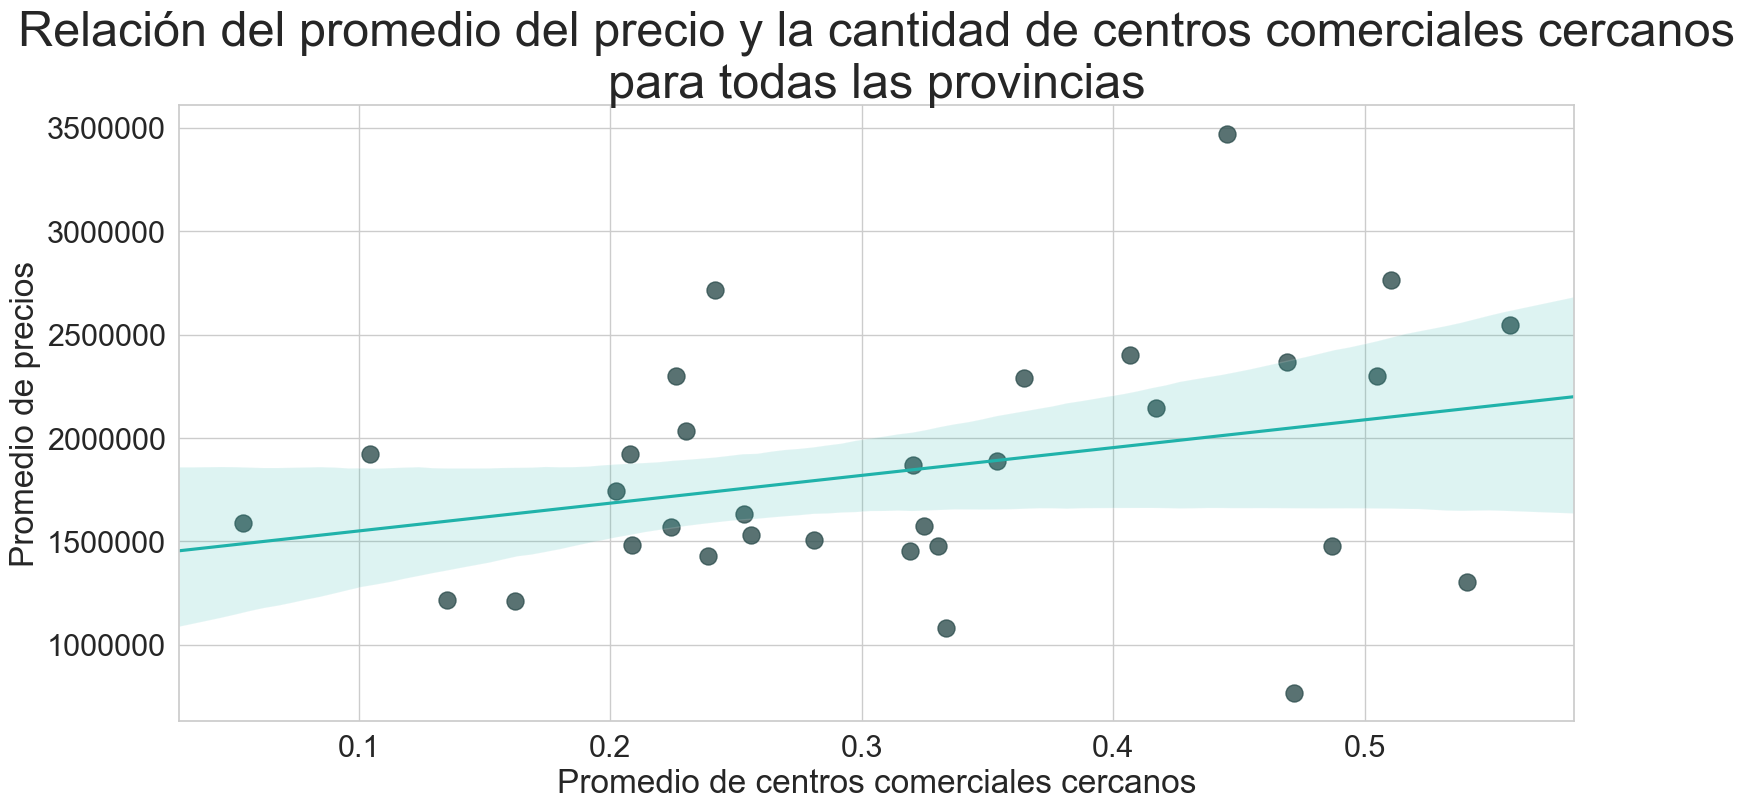

In [68]:
plot_centros_precio_relacion = sns.regplot(x="centroscomercialescercanos", y="precio", data=provincia_centrocomerciales_promedio,
                                           scatter_kws={'color': 'darkslategray', 's': 150}, line_kws={'color': 'lightseagreen'})
plot_centros_precio_relacion.set(xlabel="Promedio de centros comerciales cercanos", ylabel="Promedio de precios")
plt.title("Relación del promedio del precio y la cantidad de centros comerciales cercanos\npara todas las provincias", size = TAM_TITULO)
plt.show()